#Creating Seperate files

1. Added cutouts using albumentation
2. Implemented lrfinder as seperate file
3. display of misclassified 25 images using gradcam
4. created train, test seperate classes, previously used as functions
5. Use of ReduceLROnPlateau


##Achieved : **90.58%** using cutout and lrfinder on Resnet18 model

Remarks:
Learnings:
1. incorporating lrfinder to improve accuracy by finding best learning rate





In [1]:
! pip install albumentations==0.4.6

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [2]:
import sys
import os
sys.path.append('/content/gdrive/')
py_file_location = "/content/drive/My Drive/S10_CIFAR10_LRfinder/"
sys.path.append(os.path.abspath(py_file_location))

In [3]:
%cd '/content/drive/My Drive/S10_CIFAR10_LRfinder'
!pwd
!ls

/content/drive/My Drive/S10_CIFAR10_LRfinder
/content/drive/My Drive/S10_CIFAR10_LRfinder
data			 s10_displays.py	  s10_test_file.py
__pycache__		 s10_gradcam.py		  s10_train_file.py
s10_cifar_dataloader.py  s10_lrfinder.py
s10_cifar_modelfile.py	 s10_mainfile_cifar10.py


In [4]:
# Import your module or file
from s10_cifar_modelfile import Net, ResNet18
from s10_cifar_dataloader import AlbumentationsDataset
from s10_train_file import customTraining
from s10_test_file import customTest
from s10_gradcam import GradCam
from s10_lrfinder import LRFinder 
from s10_displays import customPlots

In [5]:
%matplotlib inline

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

In [7]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


##------------------------Call to Data Loader-------------------------

Albumentation method for data augmentation 
### use of Cutout in augmentation

In [8]:
import albumentations as A
aclass = AlbumentationsDataset()
input_batch_size =128

custom_train_tfms = [A.RandomCrop(32, 32, p=0.8),
                     A.Cutout(num_holes=3, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.6),
                     A.HorizontalFlip()]
trainset, trainloader, testset, testloader, classes = aclass.cifar10dataWithAugmentation(input_batch_size, custom_train_tfms)

Files already downloaded and verified
Files already downloaded and verified


##------------------ Visualize Input Image ---------------------------- 

---



---


Let us show some of the training images, for fun.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 3, 32, 32)


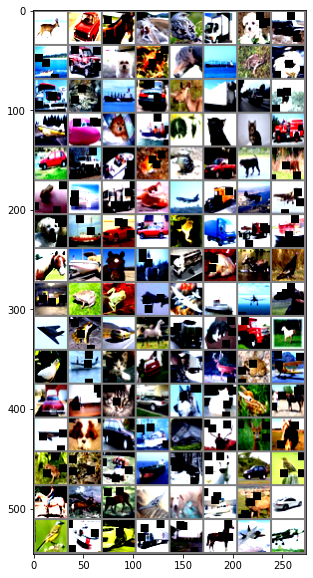

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # get some random training images
dataiter = iter(trainloader)
images, labels =  dataiter.next()
print(images.numpy().shape)  

plt.figure(figsize=(20,10))
# show images
imshow(torchvision.utils.make_grid(images))

##  ------------------------------Getting Resnet18 network from model file----------------------- 

1. Get the model
2. print summary
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [10]:
# load to device and print model summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# call now Resnet18 model
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

##------------------------------Calling training and testing  -------------------------

In [17]:
import torch.nn as nn
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.7)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda" )


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.38E-02


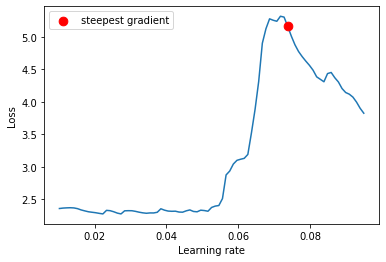

In [15]:
# print(trainloader)
# print(testloader)
lr_finder.range_test(train_loader=trainloader, val_loader=testloader, end_lr=0.1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [18]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

# train_loss = 0
# train_acc=0
# test_loss = 0
# test_acc= 0 

train_losses, train_accs=[],[]
test_losses, test_accs=[],[]

criterion = nn.CrossEntropyLoss()
model =  ResNet18().to(device)

trainClass = customTraining(train_loader= trainloader,model=model,loss_func=criterion,device=device)
testClass = customTest(test_loader=testloader,model=model,loss_func=F.cross_entropy,device=device)

optimizer = optim.SGD(model.parameters(), lr=7.38E-02, momentum=0.7 )
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 50
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train_losses, train_accs = trainClass.train(optimizer)
    test_losses, test_accs = testClass.test()
    scheduler.step(test_losses[-1])
    #scheduler.step()



  0%|          | 0/391 [00:00<?, ?it/s]

Epoch-0 lr: 0.0738


Loss=1.4163531064987183 Batch_id=390 Accuracy=42.40: 100%|██████████| 391/391 [00:59<00:00,  6.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2127, Accuracy: 5653/10000 (56.53%)

Epoch-1 lr: 0.0738


Loss=1.0072782039642334 Batch_id=390 Accuracy=61.58: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9736, Accuracy: 6616/10000 (66.16%)

Epoch-2 lr: 0.0738


Loss=0.6522396206855774 Batch_id=390 Accuracy=70.46: 100%|██████████| 391/391 [01:01<00:00,  6.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8361, Accuracy: 7083/10000 (70.83%)

Epoch-3 lr: 0.0738


Loss=0.7256644368171692 Batch_id=390 Accuracy=76.30: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6659, Accuracy: 7738/10000 (77.38%)

Epoch-4 lr: 0.0738


Loss=0.6209489107131958 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5975, Accuracy: 7934/10000 (79.34%)

Epoch-5 lr: 0.0738


Loss=0.48181939125061035 Batch_id=390 Accuracy=82.42: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6124, Accuracy: 7952/10000 (79.52%)

Epoch-6 lr: 0.0738


Loss=0.42868876457214355 Batch_id=390 Accuracy=84.39: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6363, Accuracy: 7920/10000 (79.20%)

Epoch-7 lr: 0.0738


Loss=0.4270550608634949 Batch_id=390 Accuracy=86.18: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5576, Accuracy: 8173/10000 (81.73%)

Epoch-8 lr: 0.0738


Loss=0.45860713720321655 Batch_id=390 Accuracy=87.64: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4917, Accuracy: 8405/10000 (84.05%)

Epoch-9 lr: 0.0738


Loss=0.3737433850765228 Batch_id=390 Accuracy=88.82: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5501, Accuracy: 8280/10000 (82.80%)

Epoch-10 lr: 0.0738


Loss=0.2929871082305908 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4991, Accuracy: 8487/10000 (84.87%)

Epoch-11 lr: 0.0738


Loss=0.41938313841819763 Batch_id=390 Accuracy=90.65: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5458, Accuracy: 8313/10000 (83.13%)

Epoch-12 lr: 0.0738


Loss=0.372725248336792 Batch_id=390 Accuracy=91.54: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4251, Accuracy: 8712/10000 (87.12%)

Epoch-13 lr: 0.0738


Loss=0.2512931227684021 Batch_id=390 Accuracy=92.37: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4641, Accuracy: 8601/10000 (86.01%)

Epoch-14 lr: 0.0738


Loss=0.3451356589794159 Batch_id=390 Accuracy=93.12: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5084, Accuracy: 8563/10000 (85.63%)

Epoch-15 lr: 0.0738


Loss=0.17297318577766418 Batch_id=390 Accuracy=93.59: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5068, Accuracy: 8595/10000 (85.95%)

Epoch-16 lr: 0.0738


Loss=0.16154834628105164 Batch_id=390 Accuracy=94.25: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5626, Accuracy: 8480/10000 (84.80%)

Epoch-17 lr: 0.0738


Loss=0.37950390577316284 Batch_id=390 Accuracy=94.74: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4753, Accuracy: 8689/10000 (86.89%)

Epoch-18 lr: 0.0738


Loss=0.3584027886390686 Batch_id=390 Accuracy=95.10: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4597, Accuracy: 8700/10000 (87.00%)

Epoch-19 lr: 0.0738


Loss=0.10047280788421631 Batch_id=390 Accuracy=95.54: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8715/10000 (87.15%)

Epoch-20 lr: 0.0738


Loss=0.11971919238567352 Batch_id=390 Accuracy=95.89: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4928, Accuracy: 8758/10000 (87.58%)

Epoch-21 lr: 0.0738


Loss=0.21097591519355774 Batch_id=390 Accuracy=96.20: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5179, Accuracy: 8683/10000 (86.83%)

Epoch-22 lr: 0.0738


Loss=0.2630474269390106 Batch_id=390 Accuracy=96.67: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4574, Accuracy: 8784/10000 (87.84%)

Epoch-23 lr: 0.0738


Loss=0.16047847270965576 Batch_id=390 Accuracy=96.66: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5296, Accuracy: 8699/10000 (86.99%)

Epoch-24 lr: 0.007380000000000001


Loss=0.02329733595252037 Batch_id=390 Accuracy=98.26: 100%|██████████| 391/391 [01:03<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3961, Accuracy: 8998/10000 (89.98%)

Epoch-25 lr: 0.007380000000000001


Loss=0.03330426290631294 Batch_id=390 Accuracy=98.76: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3903, Accuracy: 9026/10000 (90.26%)

Epoch-26 lr: 0.007380000000000001


Loss=0.01958809792995453 Batch_id=390 Accuracy=98.89: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3939, Accuracy: 9032/10000 (90.32%)

Epoch-27 lr: 0.007380000000000001


Loss=0.005445307120680809 Batch_id=390 Accuracy=99.03: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4026, Accuracy: 9028/10000 (90.28%)

Epoch-28 lr: 0.007380000000000001


Loss=0.024148039519786835 Batch_id=390 Accuracy=99.05: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4069, Accuracy: 9045/10000 (90.45%)

Epoch-29 lr: 0.007380000000000001


Loss=0.03569256141781807 Batch_id=390 Accuracy=99.08: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4019, Accuracy: 9035/10000 (90.35%)

Epoch-30 lr: 0.007380000000000001


Loss=0.02391064167022705 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4073, Accuracy: 9044/10000 (90.44%)

Epoch-31 lr: 0.007380000000000001


Loss=0.06502685695886612 Batch_id=390 Accuracy=99.18: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4090, Accuracy: 9033/10000 (90.33%)

Epoch-32 lr: 0.007380000000000001


Loss=0.01205518003553152 Batch_id=390 Accuracy=99.24: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4048, Accuracy: 9043/10000 (90.43%)

Epoch-33 lr: 0.007380000000000001


Loss=0.001943316892720759 Batch_id=390 Accuracy=99.26: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4086, Accuracy: 9046/10000 (90.46%)

Epoch-34 lr: 0.007380000000000001


Loss=0.04601491242647171 Batch_id=390 Accuracy=99.28: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4110, Accuracy: 9037/10000 (90.37%)

Epoch-35 lr: 0.007380000000000001


Loss=0.005741816945374012 Batch_id=390 Accuracy=99.28: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4144, Accuracy: 9025/10000 (90.25%)

Epoch-36 lr: 0.007380000000000001


Loss=0.03709839656949043 Batch_id=390 Accuracy=99.28: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4135, Accuracy: 9055/10000 (90.55%)

Epoch-37 lr: 0.0007380000000000002


Loss=0.004850064404308796 Batch_id=390 Accuracy=99.38: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4130, Accuracy: 9052/10000 (90.52%)

Epoch-38 lr: 0.0007380000000000002


Loss=0.04045631363987923 Batch_id=390 Accuracy=99.32: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4077, Accuracy: 9058/10000 (90.58%)

Epoch-39 lr: 0.0007380000000000002


Loss=0.04089757055044174 Batch_id=390 Accuracy=99.39: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4140, Accuracy: 9051/10000 (90.51%)

Epoch-40 lr: 0.0007380000000000002


Loss=0.015500744804739952 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4096, Accuracy: 9047/10000 (90.47%)

Epoch-41 lr: 0.0007380000000000002


Loss=0.0007795478450134397 Batch_id=390 Accuracy=99.32: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4098, Accuracy: 9049/10000 (90.49%)

Epoch-42 lr: 0.0007380000000000002


Loss=0.006960592232644558 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4101, Accuracy: 9043/10000 (90.43%)

Epoch-43 lr: 0.0007380000000000002


Loss=0.029924962669610977 Batch_id=390 Accuracy=99.41: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4102, Accuracy: 9046/10000 (90.46%)

Epoch-44 lr: 0.0007380000000000002


Loss=0.0015339415986090899 Batch_id=390 Accuracy=99.36: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4092, Accuracy: 9057/10000 (90.57%)

Epoch-45 lr: 0.0007380000000000002


Loss=0.002271639881655574 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4135, Accuracy: 9050/10000 (90.50%)

Epoch-46 lr: 0.0007380000000000002


Loss=0.011814098805189133 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4106, Accuracy: 9058/10000 (90.58%)

Epoch-47 lr: 0.0007380000000000002


Loss=0.056082647293806076 Batch_id=390 Accuracy=99.40: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4078, Accuracy: 9055/10000 (90.55%)

Epoch-48 lr: 7.380000000000002e-05


Loss=0.029886305332183838 Batch_id=390 Accuracy=99.49: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 9047/10000 (90.47%)

Epoch-49 lr: 7.380000000000002e-05


Loss=0.009630406275391579 Batch_id=390 Accuracy=99.45: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]



Test set: Average loss: 0.4072, Accuracy: 9056/10000 (90.56%)



[1.3770544137954712, 1.208309722328186, 0.8005277676582336, 0.7459270885467529, 0.6523137959957123]
[tensor(2.4029, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.7747, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.7672, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.2863, device='cuda:0', grad_fn=<AddBackward0>), tensor(4.0927, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.6081, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.3202, device='cuda:0', grad_fn=<AddBackward0>), tensor(3.1160, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.6526, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4402, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.4194, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.0921, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1632, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.0879, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1646, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1817, device='cuda:0', grad_fn=<Add

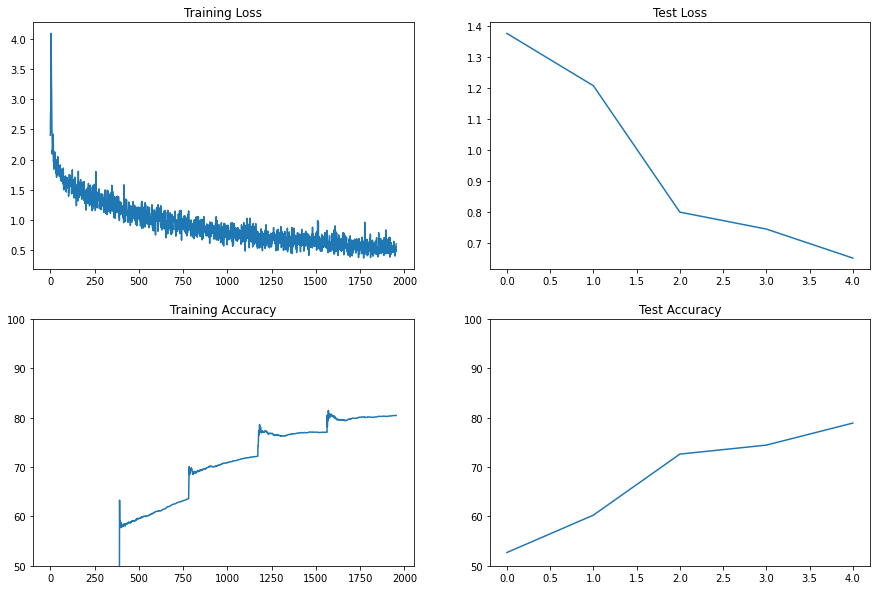

In [25]:
#call plot functions

print(test_losses)
print(train_losses)
print(train_accs)
dispFuns = customPlots(train_losses=train_losses, train_acc=train_accs, test_losses=test_losses, test_acc=test_accs)
dispFuns.plot_losses()


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




### Show misclassified images

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from s10_gradcam import GradCam

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


class Interpreter:
    def __init__(self, model, dataloader, classes):
        self.model = model
        self.dataloader = dataloader
        self.classes = classes
        self.pred = []
        self.y = []
        self.incorrect_examples = []
        self.incorrect_labels = []
        self.correct_labels = []

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        with torch.no_grad():
            for data in dataloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                self.pred.extend(predicted.cpu())
                self.y.extend(labels.cpu())
                idxs_mask = ((predicted == labels) == False).nonzero()
                self.incorrect_examples.extend(images[idxs_mask].cpu())
                self.incorrect_labels.extend(predicted[idxs_mask].cpu())
                self.correct_labels.extend(labels[idxs_mask].cpu())

        self.y_label = [classes[item] for item in self.y]
        self.pred_label = [classes[item] for item in self.pred]
        self.cm = confusion_matrix(self.y_label, self.pred_label, classes)
        self.accuracy = np.trace(self.cm) / np.sum(self.cm).astype('float')
        self.misclass = 1 - self.accuracy

    def show_misclassifications(self, k=25, gradcam=False):

        if gradcam:
            fig = plt.figure(figsize=(20, 6 * k))

            for idx in np.arange(k):
                img = self.incorrect_examples[idx][0]
                gm = GradCam(model=self.model, img_tensor=img,
                             correct_class=self.correct_labels[idx][0], classes=self.classes,
                             feature_module=self.model.layer4, target_layer_names=['1'])
                input_img, cam_img = gm.get()
                ax = fig.add_subplot(3 * k, 5, idx + 1)
                ax.set_title(f'pred: {self.classes[self.incorrect_labels[idx]]}'
                             f' / correct: {self.classes[self.correct_labels[idx]]}')
                plt.imshow(cam_img)

            fig.tight_layout()
        else:
            fig = plt.figure(figsize=(20, 6 * k))

            for idx in np.arange(k):
                ax = fig.add_subplot(3 * k, 5, idx + 1)
                ax.set_title(f'pred: {self.classes[self.incorrect_labels[idx]]}'
                             f' / correct: {self.classes[self.correct_labels[idx]]}')
                img = self.incorrect_examples[idx][0]
                imshow(img)
            fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

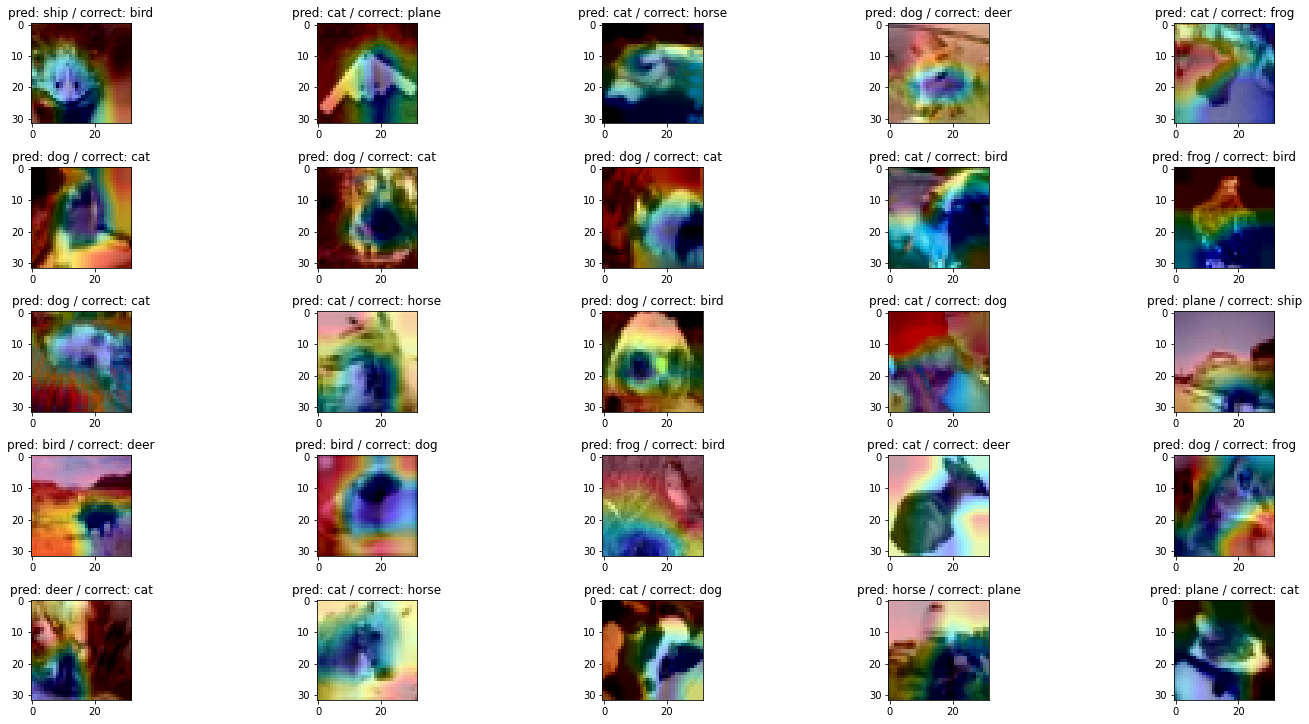

In [35]:
interpret = Interpreter(model=model, dataloader=testloader, classes=classes)
interpret.show_misclassifications(k=25,gradcam=True)

In [21]:
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# images, labels = images.to(device), labels.to(device)

# imagesToshow = images.detach().cpu()
# # print images
# imshow(torchvision.utils.make_grid(imagesToshow))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
# def classwiseAccuracy(model,device,testloader, batchSize,numClasses):
#   class_correct = list(0. for i in range(numClasses))
#   class_total = list(0. for i in range(numClasses))
#   with torch.no_grad():
#       for data in testloader:
#           images, labels = data
#           images, labels = images.to(device), labels.to(device)
#           outputs = model(images)
#           _, predicted = torch.max(outputs, 1)
#           c = (predicted == labels).squeeze()
#           for i in range(batchSize):
#               label = labels[i]
#               class_correct[label] += c[i].item()
#               class_total[label] += 1
#   for i in range(numClasses):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))


In [24]:
# classwiseAccuracy(model, device, testloader,4,10)

In [23]:
# #from gradcam import GradCam
# img_tensor_batch, labels = next(iter(testloader))
# for idx in range(10):
#   gm = GradCam(model=model, img_tensor=img_tensor_batch[idx],
#               correct_class=labels[idx], classes=classes,
#               feature_module=model.layer4, target_layer_names=['1'])
#   gm.visualize()